### Missing labels classification

This is a small exploratory study on the avaiable methods to solve the missing label classification problem.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import random
import torch.nn as nn
import torchvision as tv
import torchvision.datasets as tvd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from typing import Union

#### Additional global variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Device: cuda


####  Problem statement

Let's consider the following scenario: an image dataset was processed before using the following transformations. From this we have access only to $30%$ of the labeled data, the others does not have any labels. Predict the test partition using only this restricted info about the data. 

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # the basic transforms compositions, which will be unknown in the nest scenario    
])

In [12]:
dataset = tvd.CIFAR10(root="./data/cifar", download=True, transform=transform)

Files already downloaded and verified


In [13]:
test_dataset = tvd.CIFAR10(root="./data/cifar-test", download=True, transform=transform, train=False)

100%|██████████| 170498071/170498071 [00:27<00:00, 6283683.18it/s] 


Extracting ./data/cifar-test\cifar-10-python.tar.gz to ./data/cifar-test


In [14]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [15]:
# Reduce the number of points in the train dataset to 3000
train_dataset = dataset
train_dataset[0][0].shape

torch.Size([3, 32, 32])

In [16]:
def show(img: Union[np.ndarray, torch.Tensor], ax: plt.Axes = None, label: int = None):
    if type(img) == torch.Tensor:
        npimg = img.cpu().numpy()
    else:
        npimg = img
    if ax is None:
        ax = plt
    else:
        ax.set_title(f"Label: {label}")
    
    ax.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


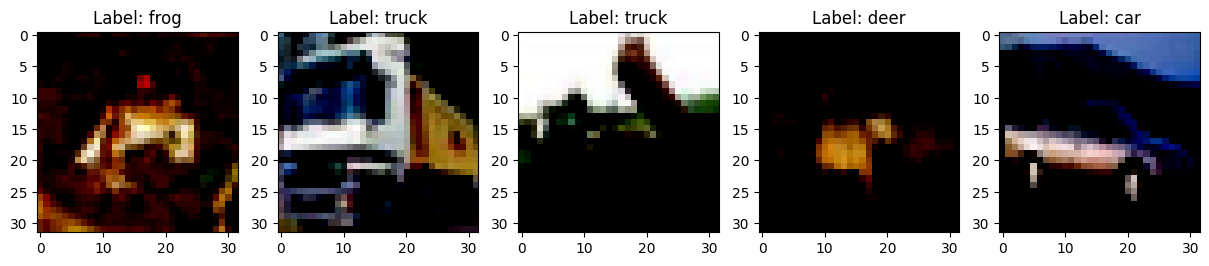

In [18]:
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    show(img=train_dataset[i][0], ax=ax[i], label=classes[train_dataset[i][1]])

### Model

In [28]:
model = tv.models.resnet50(weights=tv.models.ResNet50_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False   

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 10),
    nn.Sigmoid()
)

model = model.to(device)

In [29]:
batch_size = 16
epochs = 10
lr = 0.01
momentum = 0.9

dl = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
criterion = nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [30]:
for epoch in range(epochs):
    for idx, data in enumerate(dl):
        imgs, labels = data

        labels = labels.view(-1, 1).float()
        labels = labels.repeat([1, len(classes)])
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() # clear

        prediction = model(imgs)
        
        batch_loss = criterion(prediction, labels)
        
        batch_loss.backward() # fill
        optimizer.step() # use
        
        # Also, it works the same for {clear}, fill, use, {clear}

        if idx == len(data):
            print(f"Epoch: {epoch} Loss: {batch_loss.item():.4f}")

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [24]:
# save the current state of the models
if not os.path.exists("./models"):
    os.mkdir("./models")

torch.save(model.state_dict(), f"./models/resnet50_{epochs}_{lr}.pt")

In [25]:
test_dl = DataLoader(dataset=test_dataset, shuffle=True, batch_size=32)

In [27]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        
        labels = labels.float()
        images = images.to(device)
        labels = labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(test_dl)} test images: {correct // total} %')


Accuracy of the network on the 313 test images: 0 %


### Data tweaks